# Seattle Airbnb Data Modeling

Model predicts airbnb day prices in Seattle using feature engineering, light gradient boosting feature selection and regression. This model aims to help hosts to establish right prices. Final R2 score on test is 0.71

In [648]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.linear_model import Ridge, RidgeCV
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [649]:
df=pd.read_csv("listings_seattle.csv")
dfcal=pd.read_csv("calendar.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,1/4/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,1/4/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,1/4/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,1/4/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,1/4/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [650]:

dfcal['month']=dfcal['date'].apply(lambda x: int(x.split('-')[1]))
dfcal=dfc.rename(columns={'listing_id': 'id'})
dfcal=dfcal[['id', 'month', 'price']].copy()


In [651]:
dfcal=dfcal.dropna()
dfcal=dfcal.drop_duplicates()
del df['price']
df=pd.merge(df, dfcal, on ='id')

dfcal.head()

,id,month,price
0,241032,1,$85.00
28,241032,2,$85.00
57,241032,3,$85.00
88,241032,4,$85.00
118,241032,5,$85.00


Model evaluation function fits training data, predicts and computes score

In [652]:
def model_eval(X, y, model):
    '''
    input: X is features data frame, y is respones, model
    output: train cross validation score, test score, predicted values
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv = 5)
    test_score = r2_score(y_test, y_pred)
    return score, test_score, y_pred, y_test
def plot_dist(col):
    dfc=df[['id', col]].groupby([col]).count()
    (dfc/df.shape[0]).plot(kind="bar");

In [653]:
num_rows = df.shape[0] #Provide the number of rows in the dataset
num_cols = df.shape[1] #Provide the number of columns in the dataset
print(num_rows)
print(num_cols)
print(df.columns)

73025
93
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amen

Columns with nulls

In [654]:
nulls = set(df.columns[df.isnull().any()])#Provide a set of columns with missing values.
print(nulls)

{'host_listings_count', 'last_review', 'review_scores_value', 'host_is_superhost', 'monthly_price', 'host_response_rate', 'host_since', 'host_neighbourhood', 'summary', 'review_scores_location', 'host_acceptance_rate', 'neighbourhood', 'xl_picture_url', 'medium_url', 'host_thumbnail_url', 'host_response_time', 'review_scores_communication', 'host_total_listings_count', 'weekly_price', 'host_identity_verified', 'transit', 'review_scores_cleanliness', 'review_scores_accuracy', 'host_name', 'bathrooms', 'license', 'cleaning_fee', 'host_has_profile_pic', 'host_picture_url', 'neighborhood_overview', 'beds', 'host_location', 'host_about', 'security_deposit', 'review_scores_checkin', 'first_review', 'review_scores_rating', 'notes', 'property_type', 'thumbnail_url', 'reviews_per_month', 'square_feet', 'bedrooms', 'zipcode', 'space'}


Columns with many missing values

In [655]:
most_missing_cols = set(df.columns[abs(df.isnull().sum())>0.7*len(df)])
print(most_missing_cols)
df=df.drop(most_missing_cols, axis=1)

{'square_feet', 'license'}


Check distributions of some features

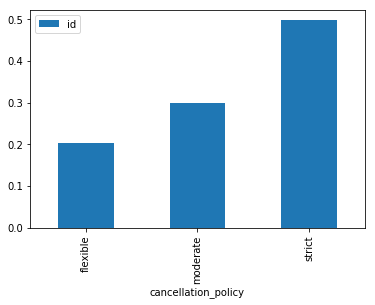

In [656]:
plot_dist('cancellation_policy')

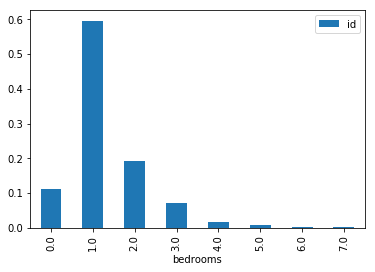

In [657]:
plot_dist('bedrooms')

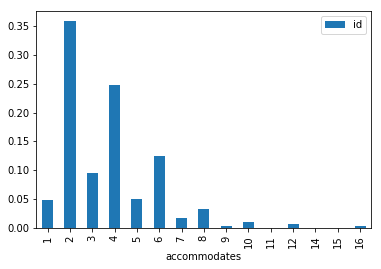

In [658]:
plot_dist('accommodates')

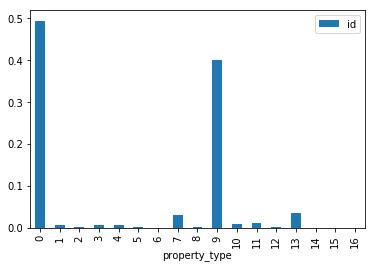

In [679]:
plot_dist('property_type')

Possible outcome columns related to price

In [659]:
out=['price', 'weekly_price', 'monthly_price']

In [660]:
dfm=df.loc[~df['monthly_price'].isnull()]
print(len(dfm))
dfw=df.loc[~df['weekly_price'].isnull()]
print(len(dfw))
print(len(df.loc[~df['price'].isnull()]))

28777
35500
73025


Preprocess numerical feature

In [661]:
df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))

In [662]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%', '')))
print(df.select_dtypes(['float', 'int', 'int64']).columns)
col_reviews=['review_scores_value', 'review_scores_rating',  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']
col_num = ['accommodates', 'host_total_listings_count', 'bedrooms', 'bathrooms', 'beds', 'host_response_rate', 'host_acceptance_rate']
# Mean function
fill_mean = lambda col: col.fillna(int(col.mean()))
# Fill the mean
df[col_num] = df[col_num].apply(fill_mean, axis=0)
for i in col_reviews:
    df[i]=df[i].fillna(0.0)

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'month', 'price'],
      dtype='object')


Numerical features

In [663]:
#This feature works better (checked) and reduce number of features
colf=df.select_dtypes(['float', 'int', 'int64']).columns
colf =[i for i in colf if i not in ['id','scrape_id']]
print(colf)

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'month', 'price']


In [664]:
df["host_total_listings_count"]=df["host_total_listings_count"].fillna(df["host_total_listings_count"].mean())

 Heat map to find which features are high correlated and may not be be used all together. We will use light gradient boosting for further features selection. All this will be also checked on final resulst optimization.

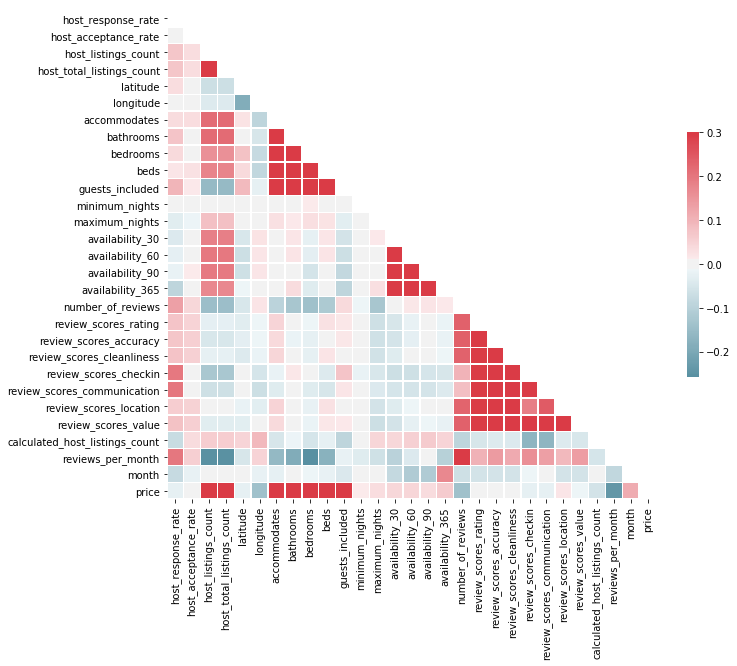

In [665]:
#first to exclude 
exc=  ['host_id']#['calculated_host_listings_count', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',  'review_scores_cleanliness', 'host_listings_count', "price"]
col = [i for i in colf if i not in exc]
corr = df[col].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [666]:
#From highly correlated features this feature works better (checked) and reduce number of features
df['totalrooms'] = df['bedrooms']+df['bathrooms']
del df['bedrooms']
del df['bathrooms']
col=df.select_dtypes(['float', 'int', 'int64']).columns
#excluded also 'host_listings_count' beacause it is almost the same as "host_total_listings_count" and it gives the same result
col =[i for i in col if i not in ['id', 'scrape_id', 'host_listings_count']]
print(col)

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'month', 'price', 'totalrooms']


Run Light Gradient Boosting on numerical feature to check first numerical feature importance and result for this model. 

In [667]:
#'host_listings_count' is also excluded beacause it is almost the same as "host_total_listings_count" and it gives the same result
del df['host_listings_count']
del df['scrape_id']
#som columns will be in exc in case they are needed later
exc=  ['host_id','id', 'maximum_nights', 'price']#['calculated_host_listings_count', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',  'review_scores_cleanliness', 'host_listings_count', "price"]

col = [i for i in col if i not in exc]
print(col)
X_num=df[col]
Y=df["price"]
#model
print(len(col))
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
score, test_score, y_pred, y_test = model_eval(X_num, Y, model)
print('all')
print('numerical train crossvalidation')
print(np.mean(score))
print('numerical test')
print(test_score)

['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'month', 'totalrooms']
25
all
numerical train crossvalidation
0.8282597556361397
numerical test
0.8427160245316488


Plot feature importances…


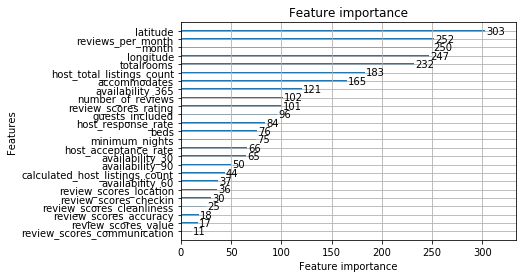

In [668]:
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=28)
plt.show()

In [669]:
#remove lowest importance values and some of highly correlated, until we have the best result at the end
exc=  ['latitude', 'longitude','host_id','maximum_nights', 'host_acceptance_rate', 'calculated_host_listings_count',  'review_scores_checkin', 'price', 'review_scores_value', 'availability_60', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',   "price"]
col = [i for i in col if i not in exc]
print(col)
X_num=df[col]
#model
model_num = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#XGBClassifier(max_depth=5, learning_rate=0.01,  sample_weight=w_array)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
score, test_score, y_pred, y_test = model_eval(X_num, Y, model)
print('selected features')
print('numerical cross validation')
print(np.mean(score))
print('numerical test')
print(test_score)

['host_response_rate', 'host_total_listings_count', 'accommodates', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'month', 'totalrooms']
selected features
numerical cross validation
0.7956479848467163
numerical test
0.8097663471449673


Plot feature importances…


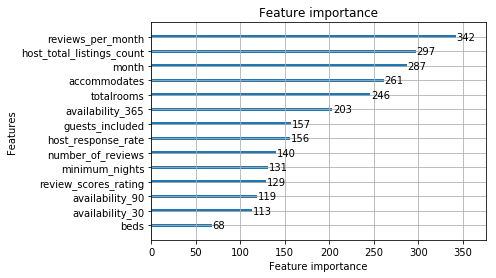

In [670]:
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=26)
plt.show()

In [671]:
df=df.drop(['experiences_offered'], axis=1)

Check categorical feature importance

In [672]:
#print(df['host_is_superhost'])
cat_col = df.select_dtypes(include=['object']).columns
df[cat_col] = df[cat_col].fillna('none')
text=['summary', 'amenities', 'name',  'notes', 'description', 'neighborhood_overview', 'transit', 'host_about']
exclude=['id', 'neighbourhood_group_cleansed', 'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col = [i for i in cat_col if i not in out+exclude+text]
print(cat_col)
le  = LabelEncoder()
for i in cat_col:
    df[i]=le.fit_transform(df[i].astype('category'))
X_cat = df[cat_col]           

['host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode', 'smart_location', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy']


all
categorical crossvalidation
0.6031031490299925
categorical test
0.6080296290055287
Plot feature importances…


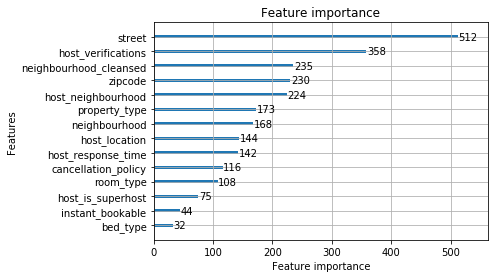

In [673]:
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=5, learning_rate=0.05)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#cross_val
score, test_score, y_pred, y_test = model_eval(X_cat, Y, model)
print('all')
print('categorical crossvalidation')
print(np.mean(score))
print('categorical test')
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=26)
plt.show()

All together with lowest importance values removed

numerical and categorical features together
crossvalidation
0.8393892294025829
test
0.853110339861868
Plot feature importances, it shows 26 features


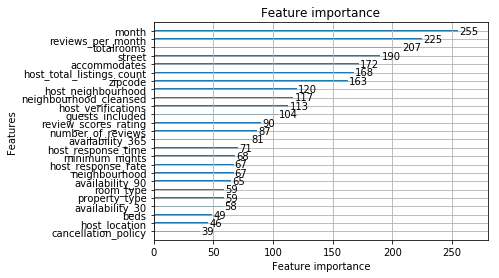

In [674]:
exclude=['id', 'instant_bookable',  'host_is_superhost',  'bed_type',  'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col =[i for i in cat_col if i not in exclude]
#model
X=df[cat_col+col]
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=5, learning_rate=0.05)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#cross_val
score, test_score, y_pred, y_test = model_eval(X, Y, model)
print('numerical and categorical features together')
print('crossvalidation')
print(np.mean(score))
print('test')
print(test_score)
print("Plot feature importances, it shows 26 features")
ax = lgb.plot_importance(model, max_num_features=26)
plt.show()

Text features processing

In [675]:
count_descp = TfidfVectorizer(max_features = 130, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_am = TfidfVectorizer(max_features = 70, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_transit = TfidfVectorizer(max_features = 70, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_n = TfidfVectorizer(max_features = 20, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_desc = count_descp.fit_transform(df["description"])
X_name = count_descp.fit_transform(df["name"])
X_transit = count_transit.fit_transform(df["transit"])
X_am = count_am.fit_transform(df['amenities'])
X_s = count_n.fit_transform(df['summary'])

Adding text feature to previous model did not improved result. Too many features can result to overfitting and text features work better with different LGB parameters. As the result the best final R2 test score is 0.92

In [676]:
X1=hstack((              X,
                         X_s,
                         X_am,
                         X_transit,      
                         X_name,
                         X_desc
          )).tocsr()
model_text = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.5, num_leaves=31, max_depth = 9)
#model_text=XGBRegressor(max_depth=5, learning_rate=0.5)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)

score1, test_score1, ypred1, y_test = model_eval(X1, Y, model_text)
#X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)
print('all')
print('score on text features')
#print(score)
print(np.mean(score1))
print(test_score1)

all
score on text features
0.9064922146619301
0.9199385419724743
